This notebook generates an image similar to that found in a Soft Matter cover associated with the paper [Self-assembly of a space-tessellating structure in the binary system of hard tetrahedra and octahedra](http://pubs.rsc.org/en/content/articlelanding/2016/sm/c6sm01180b) by Cadotte, Dshemuchadse, Damasceno, Newman, and Glotzer.

In [1]:
from collections import defaultdict, namedtuple
import itertools
from itertools import repeat
import numpy as np
import gtar
import json
import freud

import plato
import plato.draw.povray as draw_static

# set to True to enable live visualization
viz_live = True

if viz_live: 
    import vispy
    from vispy import app
    app.use_app('ipynb_webgl')
    from vispy import gloo
    import plato.draw.vispy as draw_live
else:
    import plato.draw as draw_live
import IPython

In [2]:
with gtar.GTAR('soft_matter_cluster.zip', 'r') as traj:
    positions = traj.readPath('position.f32.ind')
    orientations = traj.readPath('orientation.f32.ind')
    box = traj.readPath('box.f32.uni')
    types = traj.readPath('type.u32.ind')
    predictedTypes = traj.readPath('predicted_type.u32.ind')
    params = json.loads(traj.readStr('params.json'))

In [3]:
def center(box, positions, filter_mask):
    thetas = (positions[filter_mask, :]/np.array(box[:3])[np.newaxis, :] + .5)*2*np.pi
    sums = np.sum(np.exp(1j*thetas), axis=0)
    fractions = np.angle(sums)/2/np.pi
    fractions %= 1.
    fractions -= .5
    delta = fractions*np.array(box[:3])
    fbox = freud.box.Box(*box)
    result = np.asarray(positions - delta[np.newaxis, :], dtype=np.float32)
    fbox.wrap(result)
    return result

In [4]:
Ncolors = np.max(predictedTypes) + 1
thetas = np.arange(Ncolors)*2*np.pi*(1 - 1/((1 + np.sqrt(5))/2))
typeColors = np.ones((Ncolors, 4), dtype=np.float32)
typeColors[:, :3] = plato.cmap.cubeellipse_intensity(thetas, h=1.25, s=-np.pi/3, lam=.4, lam_r1=.2)

In [5]:
prims = [draw_live.ConvexPolyhedra() for _ in range(2)]

colors = typeColors[predictedTypes]
solidTypes = [0, 1]
shiftedPositions = center(box, positions, np.any([predictedTypes == t for t in solidTypes], axis=0))

theta = -np.pi/2
rotation = np.array([np.cos(theta/2), 0, np.sin(theta/2), 0], dtype=np.float32)

for (typ, prim) in enumerate(prims):
    if typ == 1:
        typemask = types == typ
        prim.vertices = params['shapes'][typ]
        prim.positions = shiftedPositions[typemask]
        prim.orientations = orientations[typemask]
        prim.colors = colors[typemask]
    else:
        prim.positions = [[0, 0, 0]]
        prim.orientations = [[0, 0, 0, 0]]
        prim.colors = [[0, 0, 0, 0]]

features = dict(ambient_light=.25, directional_light=np.array([(.25, .5, -1), (0, -.5, -.8)])*.9)
scene = draw_live.Scene(prims, features=features, rotation=rotation, zoom=1.6)
if viz_live:
    scene.show()

/home/mspells/dev/plato/plato/draw/Scene.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'name' in config:


In [6]:
# translucent tetrahedra, translucent octahedra, opaque tetrahedra, opaque octahedra
prims = [draw_live.ConvexPolyhedra() for _ in range(4)]

prims[0].vertices = params['shapes'][0]
prims[2].vertices = params['shapes'][0]
prims[1].vertices = params['shapes'][1]
prims[3].vertices = params['shapes'][1]

colors = typeColors[predictedTypes]
solidTypes = [0, 1]
shiftedPositions = center(box, positions, np.any([predictedTypes == t for t in solidTypes], axis=0))

solidMask = np.any([predictedTypes == t for t in solidTypes], axis=0)
fluidMask = np.logical_not(solidMask)

fluidTetrahedra = np.logical_and(fluidMask, types == 0)
fluidOctahedra = np.logical_and(fluidMask, types == 1)
solidTetrahedra = np.logical_and(solidMask, types == 0)
solidOctahedra = np.logical_and(solidMask, types == 1)

rsq = np.sum(shiftedPositions**2, axis=-1)
solidSelection = np.ones(shiftedPositions.shape[0], dtype=np.bool)

masks = [
    fluidTetrahedra,
    fluidOctahedra,
    np.logical_and(solidTetrahedra, solidSelection), 
    np.logical_and(solidOctahedra, solidSelection)
]

for (i, prim, mask) in zip(itertools.count(), prims, masks):
    prim.positions = shiftedPositions[mask]
    prim.orientations = orientations[mask]
    if i % 2:
        color = [[0./255, 98./255, 194./255]]
    else:
        color = [[255./255, (13*16 + 12)/255, 5./255]]
        
    colors = np.ones((prim.positions.shape[0], 4), dtype=np.float32)
    colors[:, :3] = color
    colors[:, 3] = .25 if i < 2 else 1
    prim.colors = colors

scene = draw_live.Scene(prims, rotation=rotation, features=features, zoom=scene.zoom)
if viz_live:
    scene.show()

/home/mspells/dev/plato/plato/draw/Scene.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'name' in config:


/home/mspells/dev/plato/plato/draw/Scene.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'name' in config:


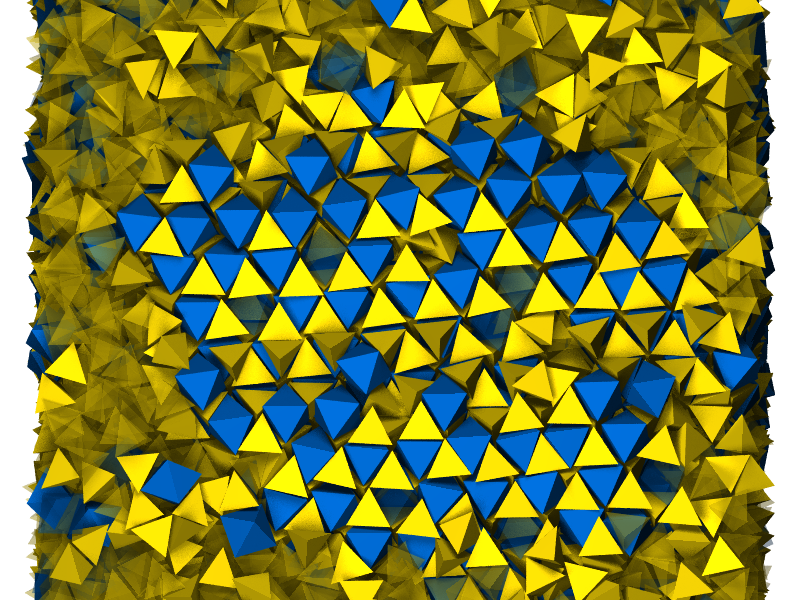

In [7]:
target = '../gallery/tetrahedra_octahedra_povray.png'
static_prims = [draw_static.ConvexPolyhedra.copy(p) for p in prims]
static_scene = draw_static.Scene(static_prims, rotation=rotation, features=features, zoom=scene.zoom)
static_scene.enable('antialiasing', .3)
static_scene.save(target)
IPython.display.Image(filename=target)